In [2]:
from __future__ import print_function, division, absolute_import, unicode_literals

import os
import shutil
import numpy as np
from collections import OrderedDict
import logging
import tensorflow as tf
import cv2
import glob

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
import numpy as np
%matplotlib inline

In [4]:
import SimpleITK as sitk

def load_itk(filename):
    itkimage = sitk.ReadImage(filename)
    ct_scan = sitk.GetArratFromImage(itkimage)
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    origin = np.array(list(reversed(itkimage.GetOriin())))
    return ct_scan,origin,spacing

def world_2_voxel(world_coordinates,origin,spacing):
    streched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates= streched_voxel_coordinates / spacing
    return voxel_coordinates

def voxel_2_world(voxel_coordinates,origin,spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [5]:
def _weight_variable(name,shape,stddev):
    print('shape :',shape,stddev)
#     return tf.get_variable(name,shape,tf.float32,tf.truncated_normal_initializer(stddev=stddev))
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev),name=name)

def _bias_variable(name,shape):
#     return tf.get_variable(name,shape,tf.float32,tf.constant_initializer(0.1,dtype=tf.float32))
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial,name=name)


def create_3d_unet(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2, summaries=True):
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    nz = tf.shape(x)[3]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,nz,channels]))
    prev_layer = x_image
    in_filters = channels
    
    output_pixels = []
    weights = []
    biases = []
    
#     with tf.variable_scope('conv1',reuse=True) as scope:
    out_filters = 48
    stddev = np.sqrt(2 / (3**2 * out_filters))

    conv1_w1 = _weight_variable('conv1_weights1',[3,3,3,in_filters,out_filters],stddev)
    conv1 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv1_w1,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv1_b1 = _bias_variable('conv1_bias1',[out_filters]) 
    conv1 = tf.nn.relu(tf.nn.bias_add(conv1,conv1_b1))
    weights.append(conv1_w1)
    biases.append(conv1_b1)
    axis = list(range(len(conv1.get_shape()) - 1))
    mean,variance = tf.nn.moments(conv1,axis)
    normed = tf.nn.batch_normalization(conv1,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters

    conv1_w2 = _weight_variable('conv1_weights2',[3,3,3,in_filters,out_filters],stddev)
    conv1 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv1_w2,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv1_b2 = _bias_variable('conv1_bias2',[out_filters])
    conv1 = tf.nn.relu(tf.nn.bias_add(conv1,conv1_b2))
    mean,variance = tf.nn.moments(conv1,axis)
    normed = tf.nn.batch_normalization(conv1,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters
    weights.append(conv1_w2)
    biases.append(conv1_b2)

    conv1_w3 = _weight_variable('conv1_weights3',[3,3,3,in_filters,out_filters],stddev)
    conv1 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv1_w3,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv1_b3 = _bias_variable('conv1_bias3',[out_filters])
    conv1 = tf.nn.relu(tf.nn.bias_add(conv1,conv1_b3))
    mean,variance = tf.nn.moments(conv1,axis)
    #   offset = 0.01 scale = 1
    normed = tf.nn.batch_normalization(conv1,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters
    weights.append(conv1_w3)
    biases.append(conv1_b3)
    output_pixels.append(conv1)
        
        
    
    down_pool = tf.nn.max_pool3d(prev_layer,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],padding='VALID')
    prev_layer = down_pool
    in_filters = out_filters

    
    
#     with tf.variable_scope('cnov2',reuse=True) as scope:
    stddev = np.sqrt(2 / (3**2 * out_filters))
    conv2_w1 = _weight_variable('conv2_weights1',[3,3,3,in_filters,out_filters],stddev)
    conv2 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv2_w1,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv2_b1 = _bias_variable('conv2_bias1',[out_filters]) 
    conv2 = tf.nn.relu(tf.nn.bias_add(conv2,conv2_b1))
    weights.append(conv2_w1)
    biases.append(conv2_b1)
    axis = list(range(len(conv2.get_shape()) - 1))
    mean,variance = tf.nn.moments(conv2,axis)
    normed = tf.nn.batch_normalization(conv2,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters

    stddev = np.sqrt(2 / (3**2 * out_filters))
    conv2_w2 = _weight_variable('conv2_weights2',[3,3,3,in_filters,out_filters],stddev)
    conv2 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv2_w2,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv2_b2 = _bias_variable('conv2_bias2',[out_filters]) 
    conv2 = tf.nn.relu(tf.nn.bias_add(conv2,conv2_b2))
    weights.append(conv2_w2)
    biases.append(conv2_b2)
    axis = list(range(len(conv2.get_shape()) - 1))
    mean,variance = tf.nn.moments(conv2,axis)
    normed = tf.nn.batch_normalization(conv2,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters

    stddev = np.sqrt(2 / (3**2 * out_filters))
    conv2_w3 = _weight_variable('conv2_weights3',[3,3,3,in_filters,out_filters],stddev)
    conv2 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv2_w3,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv2_b3 = _bias_variable('conv2_bias3',[out_filters]) 
    conv2 = tf.nn.relu(tf.nn.bias_add(conv2,conv2_b3))
    weights.append(conv2_w3)
    biases.append(conv2_b3)
    axis = list(range(len(conv2.get_shape()) - 1))
    mean,variance = tf.nn.moments(conv2,axis)
    normed = tf.nn.batch_normalization(conv2,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters

    stddev = np.sqrt(2 / (3**2 * out_filters))
    conv2_w4 = _weight_variable('conv2_weights4',[3,3,3,in_filters,out_filters],stddev)
    conv2 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv2_w4,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv2_b4 = _bias_variable('conv2_bias4',[out_filters]) 
    conv2 = tf.nn.relu(tf.nn.bias_add(conv2,conv2_b4))
    weights.append(conv2_w4)
    biases.append(conv2_b4)
    axis = list(range(len(conv2.get_shape()) - 1))
    mean,variance = tf.nn.moments(conv2,axis)
    normed = tf.nn.batch_normalization(conv2,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters
    output_pixels.append(conv2)
        
        
#     with tf.variable_scope('upscale',reuse=True) as scope:
    x_shape = tf.shape(prev_layer)
    output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2,x_shape[3]*2, x_shape[4]])
    stddev = np.sqrt(2 / (2**2 * out_filters))
    kernel = _weight_variable('kernel',[2,2,2,out_filters,in_filters],stddev)
    upscale = tf.nn.conv3d_transpose(prev_layer,kernel,output_shape,[1,2,2,2,1],padding='VALID')
    weights.append(kernel)
    prev_layer = upscale
    output_pixels.append(upscale)
    
    x1_shape = tf.shape(conv1)
    x2_shape = tf.shape(upscale)
    
    offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2,(x1_shape[3] - x2_shape[3]) // 2, 0]
    size = [-1, x2_shape[1], x2_shape[2],x2_shape[3], -1]
    x1_crop = tf.slice(conv1, offsets, size)
    prev_layer = tf.concat([x1_crop, upscale], 4)
    in_filters = out_filters*2
    
#     with tf.variable_scope('conv3',reuse=True) as scope:
    out_filters = 96
    stddev = np.sqrt(2 / (3**2 * out_filters))

    conv3_w1 = _weight_variable('conv3_weights1',[3,3,3,in_filters,out_filters],stddev)
    conv3 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv3_w1,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv3_b1 = _bias_variable('conv3_bias1',[out_filters]) 
    conv3 = tf.nn.relu(tf.nn.bias_add(conv3,conv3_b1))
    weights.append(conv3_w1)
    biases.append(conv3_b1)
#         prev_layer = conv3
    axis = list(range(len(conv3.get_shape()) - 1))
    mean,variance = tf.nn.moments(conv3,axis)
    normed = tf.nn.batch_normalization(conv3,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters

    conv3_w2 = _weight_variable('conv3_weights2',[3,3,3,in_filters,out_filters],stddev)
    conv3 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv3_w2,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv3_b2 = _bias_variable('conv3_bias2',[out_filters]) 
    conv3 = tf.nn.relu(tf.nn.bias_add(conv3,conv3_b2))
    weights.append(conv3_w2)
    biases.append(conv3_b2)
#         prev_layer = conv3
    axis = list(range(len(conv3.get_shape()) - 1))
    mean,variance = tf.nn.moments(conv3,axis)
    normed = tf.nn.batch_normalization(conv3,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters

    conv3_w3 = _weight_variable('conv3_weights3',[3,3,3,in_filters,out_filters],stddev)
    conv3 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv3_w3,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv3_b3 = _bias_variable('conv3_bias3',[out_filters]) 
    conv3 = tf.nn.relu(tf.nn.bias_add(conv3,conv3_b3))
    weights.append(conv3_w3)
    biases.append(conv3_b3)
#         prev_layer = conv3
    axis = list(range(len(conv3.get_shape()) - 1))
    mean,variance = tf.nn.moments(conv3,axis)
    normed = tf.nn.batch_normalization(conv3,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters

    conv3_w4 = _weight_variable('conv3_weights4',[3,3,3,in_filters,out_filters],stddev)
    conv3 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv3_w4,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv3_b4 = _bias_variable('conv3_bias4',[out_filters]) 
    conv3 = tf.nn.relu(tf.nn.bias_add(conv3,conv3_b4))
    weights.append(conv3_w4)
    biases.append(conv3_b4)
#         prev_layer = conv3
    axis = list(range(len(conv3.get_shape()) - 1))
    mean,variance = tf.nn.moments(conv3,axis)
    normed = tf.nn.batch_normalization(conv3,mean=mean,variance=variance,offset=None,scale=None,variance_epsilon=0.001)
    prev_layer = normed
    in_filters = out_filters

    conv3_w5 = _weight_variable('conv3_weights5',[3,3,3,in_filters,2],stddev)
    conv3 = tf.nn.dropout(tf.nn.conv3d(prev_layer,conv3_w5,[1,1,1,1,1],padding='VALID'),keep_prob)
    conv3_b5 = _bias_variable('conv3_bias5',[2]) 
    conv3 = tf.nn.relu(tf.nn.bias_add(conv3,conv3_b5))
    weights.append(conv3_w5)
    biases.append(conv3_b5)
    prev_layer = conv3
    in_filters = out_filters
    output_pixels.append(conv3)
    
    
    return prev_layer,weights,biases,output_pixels

In [10]:

#从原始数据集中切割模型训练所用的数据

import pandas as pd
import numpy as np
import scipy
import glob
import os
import time
import pickle

def seq(start, stop, step=1):
#     n = int(round((stop - start)/float(step)))
#     if n > 1:
#         return([start + step*i for i in range(n+1)])
#     else:
#         return []
    return np.arange(int(start/step)-2,int(stop/step)+2)

    
df = pd.read_csv('../csv/train/annotations.csv')
traindata_files = glob.glob('../nodule_cubes/train_data/npy/*.npy')
f = open('../nodule_cubes/train_data/pkl/origion.pkl','rb')
origins = pickle.load(f)
f.close()
f = open('../nodule_cubes/train_data/pkl/old_spacing.pkl','rb')
old_spacings = pickle.load(f)
f.close()

f = open('../nodule_cubes/train_data/pkl/new_spacing.pkl','rb')
new_spacings = pickle.load(f)
f.close()


# trans = [[0,0,0],[-8,0,0],[0,-8,0],[0,0,-8],[8,0,0],[0,8,0],[0,0,8]]
ind = 0
for traindata_file in traindata_files[:]:
    ind += 1
    t1 = time.time()
    ct_id = os.path.basename(traindata_file)[:-4]
    train_data = np.load(traindata_file)
    image_mask = np.zeros_like(train_data)
    mask3d = train_data > -700
    label_weight = np.zeros((train_data.shape[0],train_data.shape[1],train_data.shape[2],2))
    label_weight[:,:,:,0] = 1
    origin = origins[ct_id]
    spacing = new_spacings[ct_id]
    
    patient = df[df['seriesuid']==ct_id]
    if patient.shape[0] == 0:
        continue

    for i in range(patient.shape[0]):
        data = np.zeros((64,64,64))
        label = np.zeros((32,32,32,2))
        
        col = patient.iloc[i]
        radius = np.ceil(col['diameter_mm']/spacing.min())/2
        coordZ = col['coordZ']
        coordY = col['coordY']
        coordX = col['coordX']
        cz,cy,cx = world_2_voxel(np.array([coordZ,coordY,coordX]),origin,spacing)
#         try:
#             data[:,:,:] = train_data[int(cz)-32:int(cz)+32,int(cy)-32:int(cy)+32,int(cx)-32:int(cx)+32]
#         except ValueError as e:
#             print("=========  ValueError :",cz,cy,cx)
#             continue
        label_weight[int(cz),int(cy),int(cx),1] = 4.0
        noduleRange = seq(-radius, radius, spacing[0])
        for tx in noduleRange:
            for ty in noduleRange:
                for tz in noduleRange:
                    tmp_coords = np.array([int(cz)+tz,int(cy)+ty,int(cx)+tx])
                    dist = np.linalg.norm(np.array([int(cz),int(cy),int(cx)])-tmp_coords)
                    if (dist < radius+1) and (mask3d[np.int0(tmp_coords[0]),np.int0(tmp_coords[1]),np.int0(tmp_coords[2])] ==1):
#                         image_mask[np.int0(tmp_coords[0]),np.int0(tmp_coords[1]),np.int0(tmp_coords[2])] = int(1)
#                         if mask3d[np.int0(tmp_coords[0]),np.int0(tmp_coords[1]),np.int0(tmp_coords[2])] ==1:
#                         weight = 4.0 - np.log2((dist+1)**2)
                        weight = 4.0 - np.log((dist+1))
                        label_weight[np.int0(tmp_coords[0]),np.int0(tmp_coords[1]),np.int0(tmp_coords[2]),1] = weight
                        label_weight[np.int0(tmp_coords[0]),np.int0(tmp_coords[1]),np.int0(tmp_coords[2]),0] = 0
#         label = np.zeros((64,64,64,2))
#         label[:,:,:,1] = image_mask[int(cz)-32:int(cz)+32,int(cy)-32:int(cy)+32,int(cx)-32:int(cx)+32]
#         label[:,:,:,0] = 1 - image_mask[int(cz)-32:int(cz)+32,int(cy)-32:int(cy)+32,int(cx)-32:int(cx)+32]
#         np.save('../unet_3d_valdata/'+ct_id+"_data_"+str(i)+".npy",data)
#         np.save('../unet_3d_valdata/'+ct_id+'_label_'+str(i)+".npy",label)
#         label = np.zeros((64,64,64,2))
#         label[:,:,:,:] = label_weight[int(cz)-32:int(cz)+32,int(cy)-32:int(cy)+32,int(cx)-32:int(cx)+32,:]
#         np.save('../unet_3d_valdata/'+ct_id+'_label_weighted'+str(i)+".npy",label)
        
        # 数据增广，包括固定平移以及随机平移
        trans = [[0,0,0],[-8,0,0],[0,-8,0],[0,0,-8],[8,0,0],[0,8,0],[0,0,8]]
        for _ in range(10):
            trans.append([np.random.randint(-10,10),np.random.randint(-10,10),np.random.randint(-10,10)])
    
        for trans_z,trans_y,trans_x in trans:
            try:
                data[:,:,:] = train_data[int(cz)+trans_z-32:int(cz)+trans_z+32,int(cy)+trans_y-32:int(cy)+trans_y+32,int(cx)+trans_x-32:int(cx)+trans_x+32]
                label[:,:,:,:] = label_weight[int(cz)+trans_z-16:int(cz)+trans_z+16,int(cy)+trans_y-16:int(cy)+trans_y+16,int(cx)+trans_x-16:int(cx)+trans_x+16,:]
                if np.sum(label) < 15:
                    continue
                np.save('../unet_3d_traindata/'+ct_id+"_data_"+str(i)+"_"+str(trans_z)+"_"+str(trans_y)+"_"+str(trans_x)+".npy",data)
                np.save('../unet_3d_traindata/'+ct_id+"_label_"+str(i)+"_"+str(trans_z)+"_"+str(trans_y)+"_"+str(trans_x)+".npy",label)
            except ValueError as e:
                continue
    
    t2 = time.time()
    print("[ %d ] %s time: %f" % (ind,ct_id,(t2-t1)))
                                           
        
                                        

[ 1 ] LKDS-00001 time: 0.875215
[ 2 ] LKDS-00003 time: 1.577871
[ 3 ] LKDS-00004 time: 2.232676
[ 4 ] LKDS-00005 time: 0.565741
[ 5 ] LKDS-00007 time: 1.088456
[ 6 ] LKDS-00011 time: 0.766372
[ 7 ] LKDS-00013 time: 0.866413
[ 8 ] LKDS-00015 time: 1.075990
[ 9 ] LKDS-00016 time: 1.478942
[ 10 ] LKDS-00019 time: 0.789790
[ 11 ] LKDS-00020 time: 3.327226
[ 12 ] LKDS-00021 time: 0.810491
[ 13 ] LKDS-00023 time: 1.074623
[ 14 ] LKDS-00025 time: 0.999910
[ 15 ] LKDS-00026 time: 0.936111
[ 16 ] LKDS-00028 time: 0.721319
[ 17 ] LKDS-00029 time: 0.669736
[ 18 ] LKDS-00030 time: 1.145899
[ 19 ] LKDS-00035 time: 1.270299
[ 20 ] LKDS-00036 time: 0.684417
[ 21 ] LKDS-00038 time: 0.662636
[ 22 ] LKDS-00039 time: 1.257677
[ 23 ] LKDS-00040 time: 1.986893
[ 24 ] LKDS-00041 time: 1.582417
[ 25 ] LKDS-00042 time: 15.910706
[ 26 ] LKDS-00043 time: 1.408535
[ 27 ] LKDS-00044 time: 0.917874
[ 28 ] LKDS-00047 time: 1.112220
[ 29 ] LKDS-00050 time: 1.344406
[ 30 ] LKDS-00051 time: 0.956711
[ 31 ] LKDS-00052 

#  创建模型

In [6]:
def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")
#     return tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=output_map)

def pixel_wise_softmax(output_map):
    exponential_map = tf.exp(output_map)
    sum_exp = tf.reduce_sum(exponential_map, 4, keep_dims=True)
    tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1,1, tf.shape(output_map)[4]]))
    return tf.div(exponential_map,tensor_sum_exp)

def crop_to_shape(data, shape):
    offset0 = (data.shape[1] - shape[0])//2
    offset1 = (data.shape[2] - shape[1])//2
    offset2 = (data.shape[3] - shape[2])//2
    return data[:,offset0:(-offset0), offset1:(-offset1),offset2:(-offset2),:]

input_x = tf.placeholder("float32",[None,None,None,None])
input_y = tf.placeholder("float32",[None,None,None,None,2])
keep_prob = tf.placeholder(tf.float32)

nx = tf.shape(input_y)[1]
ny = tf.shape(input_y)[2]
nz = tf.shape(input_y)[3]
unet_label = tf.reshape(input_y, tf.stack([-1,nx,ny,nz,2]))

logits,weights,biases,output_pixels = create_3d_unet(input_x,keep_prob,1,2)
logits_shape = tf.shape(logits)

predictor = pixel_wise_softmax(logits)
cost = tf.reduce_mean(cross_entropy(tf.reshape(unet_label, [-1, 2]),tf.reshape(predictor,[-1,2])))
gradients_node = tf.gradients(cost, weights)
correct_pred = tf.equal(tf.argmax(predictor, 4), tf.argmax(unet_label, 4))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


# global_step = tf.Variable(0)
# learning_rate_node = tf.train.exponential_decay(learning_rate=0.1, 
#                                                         global_step=global_step, 
#                                                         decay_steps=100,  
#                                                         decay_rate=0.90, 
#                                                         staircase=True)
# optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate_node,momentum=0.99).minimize(cost,global_step=global_step)
    
    
#     print(output)

shape : [3, 3, 3, 1, 48] 0.068041381744
shape : [3, 3, 3, 48, 48] 0.068041381744
shape : [3, 3, 3, 48, 48] 0.068041381744
shape : [3, 3, 3, 48, 48] 0.068041381744
shape : [3, 3, 3, 48, 48] 0.068041381744
shape : [3, 3, 3, 48, 48] 0.068041381744
shape : [3, 3, 3, 48, 48] 0.068041381744
shape : [2, 2, 2, 48, 48] 0.102062072616
shape : [3, 3, 3, 96, 96] 0.0481125224325
shape : [3, 3, 3, 96, 96] 0.0481125224325
shape : [3, 3, 3, 96, 96] 0.0481125224325
shape : [3, 3, 3, 96, 96] 0.0481125224325
shape : [3, 3, 3, 96, 2] 0.0481125224325


In [9]:
global_step = tf.Variable(0)
learning_rate_node = tf.train.exponential_decay(learning_rate=0.01, 
                                                        global_step=global_step, 
                                                        decay_steps=100,  
                                                        decay_rate=0.95, 
                                                        staircase=True)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate_node,momentum=0.9,use_nesterov=True).minimize(cost,global_step=global_step)

# optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001,decay=0.9,momentum=0.66).minimize(cost,global_step=global_step)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
saver = tf.train.Saver()
saver.restore(sess,'./unet3d_models_7/ecpho_8/unet3d_model.ckpt')

##  训练模型

In [ ]:
import glob
import numpy as np
data_files = glob.glob('../unet_3d_traindata/*_data_*.npy')

np.random.shuffle(data_files)
train_datafiles = data_files[:-10]
val_datafiles = data_files[-10:]  


evaled_weights = []
saver = tf.train.Saver()
# sess = tf.InteractiveSession()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
val_costs = []
val_accs = []
for val_datafile in val_datafiles[:20]:
    val_data = np.load(val_datafile)
    val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
    val_norm[val_norm > 1] = 1
    val_norm[val_norm < 0] = 0
    val_norm = np.reshape(val_norm,[1,64,64,64])
    val_label = np.load(val_datafiles[0].replace('_data_','_label_weighted'))
    val_label = np.reshape(val_label,[1,64,64,64,2])
    
    val_cost,val_output_shape,val_acc = sess.run([cost,logits_shape,accuracy],
                                       feed_dict={x:val_norm,y:crop_to_shape(val_label,[32,32,32,2]),keep_prob:0.5})
    print('val loss: %f ,val acc : %f' % (val_cost,val_acc))
    val_costs.append(val_cost)
    val_accs.append(val_acc)
print(np.mean(val_cost),np.mean(val_acc))

for ecpho in range(20):
    iteration = 0
    train_loss = []
    train_accs = []
    for train_datafile in train_datafiles:
        iteration += 1
        train_data = np.load(train_datafile)
        train_norm = (train_data.astype('float32')-(-1000))/(400 - (-1000))
        train_norm[train_norm > 1] = 1
        train_norm[train_norm < 0] = 0
        train_norm = np.reshape(train_norm,[1,64,64,64])
        train_label = np.load(train_datafile.replace('_data_','_label_weighted'))
        train_label = np.reshape(train_label,[1,64,64,64,2])
        _,train_cost,train_output_shape,train_acc,ws = sess.run([optimizer,cost,logits_shape,accuracy,weights],
                                       feed_dict={x:train_norm,y:crop_to_shape(train_label,[32,32,32,2]),keep_prob:0.5})
        evaled_weights.extend(ws)
        train_loss.append(train_cost)
        train_accs.append(train_acc)
        val_costs = []
        val_accs = []
        for val_datafile in val_datafiles[:10]:
            val_data = np.load(val_datafile)
            val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
            val_norm[val_norm > 1] = 1
            val_norm[val_norm < 0] = 0
            val_norm = np.reshape(val_norm,[1,64,64,64])
            val_label = np.load(val_datafiles[0].replace('_data_','_label_weighted'))
            val_label = np.reshape(val_label,[1,64,64,64,2])
            val_cost,val_output_shape,val_acc = sess.run([cost,logits_shape,accuracy],
                                           feed_dict={x:val_norm,y:crop_to_shape(val_label,[32,32,32,2]),keep_prob:0.5})
            val_costs.append(val_cost)
            val_accs.append(val_acc)
        print('[ ecpho : %d  iter :%d ]train loss : %f ,train acc: %f ,val loss : %f ,val acc : %f' % (ecpho,iteration,train_cost,train_acc,np.mean(val_cost),np.mean(val_acc)))
    print("=============================================")
    print("[ %d ] average train loss : %f train acc : %f" % (ecpho,np.mean(train_loss),np.mean(train_accs)))
    
    modelpath = './unet3d_models_3/ecpho_'+str(ecpho)
    if not os.path.exists(modelpath):
        os.mkdir(modelpath)
    saver.save(sess,modelpath+'/unet3d_model.ckpt')


val loss: 0.597832 ,val acc : 0.650787
0.597832 0.650787
[ ecpho : 0  iter :1 ]train loss : 0.605351 ,train acc: 0.646454 ,val loss : 0.596176 ,val acc : 0.654388
[ ecpho : 0  iter :2 ]train loss : 0.658462 ,train acc: 0.621246 ,val loss : 0.599714 ,val acc : 0.651825
[ ecpho : 0  iter :3 ]train loss : 0.593126 ,train acc: 0.651398 ,val loss : 0.593506 ,val acc : 0.653351
[ ecpho : 0  iter :4 ]train loss : 0.631005 ,train acc: 0.644623 ,val loss : 0.589591 ,val acc : 0.655548
[ ecpho : 0  iter :5 ]train loss : 0.583740 ,train acc: 0.652069 ,val loss : 0.582530 ,val acc : 0.656555
[ ecpho : 0  iter :6 ]train loss : 0.579801 ,train acc: 0.650238 ,val loss : 0.579180 ,val acc : 0.656494
[ ecpho : 0  iter :7 ]train loss : 0.601668 ,train acc: 0.650909 ,val loss : 0.573023 ,val acc : 0.661194
[ ecpho : 0  iter :8 ]train loss : 0.628190 ,train acc: 0.615784 ,val loss : 0.564185 ,val acc : 0.664673
[ ecpho : 0  iter :9 ]train loss : 0.626660 ,train acc: 0.637177 ,val loss : 0.567205 ,val acc 

In [6]:
import glob
import numpy as np
data_files = glob.glob('../unet_3d_traindata/*_data_*.npy')
valdata_files = glob.glob('../unet_3d_valdata/*_data_*.npy')

print(len(data_files))
print(len(valdata_files))

np.random.shuffle(data_files)
np.random.shuffle(data_files)
np.random.shuffle(valdata_files)
train_datafiles = data_files[:]
val_datafiles = valdata_files[:10]


evaled_weights = []
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
val_costs = []
val_accs = []
for val_datafile in val_datafiles[:2]:
    val_data = np.load(val_datafile)
    val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
    val_norm[val_norm > 1] = 1
    val_norm[val_norm < 0] = 0
    val_norm = np.reshape(val_norm,[1,64,64,64])
    val_label = np.load(val_datafiles[0].replace('_data_','_label_'))
    val_label = np.reshape(val_label,[1,32,32,32,2])
    
    val_cost,val_output_shape,val_acc = sess.run([cost,logits_shape,accuracy],
                                       feed_dict={input_x:val_norm,input_y:val_label,keep_prob:0.5})
    print('val loss: %f ,val acc : %f' % (val_cost,val_acc))
    val_costs.append(val_cost)
    val_accs.append(val_acc)
print(np.mean(val_cost),np.mean(val_acc))

for ecpho in range(10):
    iteration = 0
    train_loss = []
    train_accs = []
    #tmp_tranfiles = train_datafiles[ecpho*5000:(ecpho + 1)*5000]
    tmp_tranfiles = np.random.choice(train_datafiles,5000)
    for idx in np.arange(0,len(tmp_tranfiles),5):
        iteration += 1
        tmp_files = tmp_tranfiles[idx:idx+3]
        train_datas = []
        train_labels = []
        for train_datafile in tmp_files:
            train_data = np.load(train_datafile)
            train_label = np.load(train_datafile.replace('_data_','_label_'))
            train_norm = (train_data.astype('float32')-(-1000))/(400 - (-1000))
            train_norm[train_norm > 1] = 1
            train_norm[train_norm < 0] = 0
            train_datas.append(train_norm)
            train_labels.append(train_label)
        
        train_datas = np.array(train_datas)
        train_labels = np.array(train_labels)
        _,train_cost,train_output_shape,train_acc,ws = sess.run([optimizer,cost,logits_shape,accuracy,weights],
                                       feed_dict={input_x:train_datas,input_y:train_labels,keep_prob:0.5})
        train_loss.append(train_cost)
        train_accs.append(train_acc)
        val_costs = []
        val_accs = []
        for val_datafile in val_datafiles[:10]:
            val_data = np.load(val_datafile)
            val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
            val_norm[val_norm > 1] = 1
            val_norm[val_norm < 0] = 0
            val_norm = np.reshape(val_norm,[1,64,64,64])
            val_label = np.load(val_datafiles[0].replace('_data_','_label_'))
            val_label = np.reshape(val_label,[1,32,32,32,2])
            val_cost,val_output_shape,val_acc = sess.run([cost,logits_shape,accuracy],
                                           feed_dict={input_x:val_norm,input_y:val_label,keep_prob:0.5})
            val_costs.append(val_cost)
            val_accs.append(val_acc)
        print('[ ecpho : %d  iter :%d ]train loss : %f ,train acc: %f ,val loss : %f ,val acc : %f' % (ecpho,iteration,train_cost,train_acc,np.mean(val_cost),np.mean(val_acc)))
    print("=============================================")
    print("[ %d ] average train loss : %f train acc : %f" % (ecpho,np.mean(train_loss),np.mean(train_accs)))
    
    modelpath = './unet3d_models_7/ecpho_'+str(ecpho)
    if not os.path.exists(modelpath):
        os.mkdir(modelpath)
    saver.save(sess,modelpath+'/unet3d_model.ckpt')


16040
165
val loss: 0.689933 ,val acc : 0.648895
val loss: 0.689363 ,val acc : 0.649109
0.689363 0.649109
[ ecpho : 0  iter :1 ]train loss : 0.654566 ,train acc: 0.654521 ,val loss : 0.704670 ,val acc : 0.644470
[ ecpho : 0  iter :2 ]train loss : 0.635287 ,train acc: 0.656444 ,val loss : 0.706882 ,val acc : 0.639008
[ ecpho : 0  iter :3 ]train loss : 0.618558 ,train acc: 0.660981 ,val loss : 0.697151 ,val acc : 0.641724
[ ecpho : 0  iter :4 ]train loss : 0.638679 ,train acc: 0.657430 ,val loss : 0.702251 ,val acc : 0.646545
[ ecpho : 0  iter :5 ]train loss : 0.610012 ,train acc: 0.658193 ,val loss : 0.695565 ,val acc : 0.646637
[ ecpho : 0  iter :6 ]train loss : 0.618261 ,train acc: 0.656739 ,val loss : 0.719544 ,val acc : 0.641602
[ ecpho : 0  iter :7 ]train loss : 0.636098 ,train acc: 0.658580 ,val loss : 0.708617 ,val acc : 0.642242
[ ecpho : 0  iter :8 ]train loss : 0.784518 ,train acc: 0.643708 ,val loss : 0.705656 ,val acc : 0.643616
[ ecpho : 0  iter :9 ]train loss : 0.612606 ,t

In [6]:
import glob
import numpy as np
data_files = glob.glob('../unet_3d_traindata/*_data_*.npy')
valdata_files = glob.glob('../unet_3d_valdata/*_data_*.npy')

print(len(data_files))
print(len(valdata_files))

np.random.shuffle(data_files)
np.random.shuffle(data_files)
np.random.shuffle(valdata_files)
train_datafiles = data_files[:]
val_datafiles = valdata_files[:10]


evaled_weights = []
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
val_costs = []
val_accs = []
for val_datafile in val_datafiles[:2]:
    val_data = np.load(val_datafile)
    val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
    val_norm[val_norm > 1] = 1
    val_norm[val_norm < 0] = 0
    val_norm = np.reshape(val_norm,[1,64,64,64])
    val_label = np.load(val_datafiles[0].replace('_data_','_label_'))
    val_label = np.reshape(val_label,[1,32,32,32,2])
    
    val_cost,val_output_shape,val_acc = sess.run([cost,logits_shape,accuracy],
                                       feed_dict={input_x:val_norm,input_y:val_label,keep_prob:0.5})
    print('val loss: %f ,val acc : %f' % (val_cost,val_acc))
    val_costs.append(val_cost)
    val_accs.append(val_acc)
print(np.mean(val_cost),np.mean(val_acc))

for ecpho in range(5):
    iteration = 0
    train_loss = []
    train_accs = []
    #tmp_tranfiles = train_datafiles[ecpho*5000:(ecpho + 1)*2000]
    tmp_tranfiles = np.random.choice(train_datafiles,2000)
    for idx in np.arange(0,len(tmp_tranfiles),5):
        iteration += 1
        tmp_files = tmp_tranfiles[idx:idx+3]
        train_datas = []
        train_labels = []
        for train_datafile in tmp_files:
            train_data = np.load(train_datafile)
            train_label = np.load(train_datafile.replace('_data_','_label_'))
            train_norm = (train_data.astype('float32')-(-1000))/(400 - (-1000))
            train_norm[train_norm > 1] = 1
            train_norm[train_norm < 0] = 0
            train_datas.append(train_norm)
            train_labels.append(train_label)
        
        train_datas = np.array(train_datas)
        train_labels = np.array(train_labels)
        _,train_cost,train_output_shape,train_acc,ws = sess.run([optimizer,cost,logits_shape,accuracy,weights],
                                       feed_dict={input_x:train_datas,input_y:train_labels,keep_prob:0.5})
        train_loss.append(train_cost)
        train_accs.append(train_acc)
        val_costs = []
        val_accs = []
        for val_datafile in val_datafiles[:10]:
            val_data = np.load(val_datafile)
            val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
            val_norm[val_norm > 1] = 1
            val_norm[val_norm < 0] = 0
            val_norm = np.reshape(val_norm,[1,64,64,64])
            val_label = np.load(val_datafiles[0].replace('_data_','_label_'))
            val_label = np.reshape(val_label,[1,32,32,32,2])
            val_cost,val_output_shape,val_acc = sess.run([cost,logits_shape,accuracy],
                                           feed_dict={input_x:val_norm,input_y:val_label,keep_prob:0.5})
            val_costs.append(val_cost)
            val_accs.append(val_acc)
        print('[ ecpho : %d  iter :%d ]train loss : %f ,train acc: %f ,val loss : %f ,val acc : %f' % (ecpho,iteration,train_cost,train_acc,np.mean(val_cost),np.mean(val_acc)))
    print("=============================================")
    print("[ %d ] average train loss : %f train acc : %f" % (ecpho,np.mean(train_loss),np.mean(train_accs)))
    
    modelpath = './unet3d_models_7/ecpho_'+str(ecpho)
    if not os.path.exists(modelpath):
        os.mkdir(modelpath)
    saver.save(sess,modelpath+'/unet3d_model.ckpt')


16103
17
val loss: 0.607566 ,val acc : 0.650421
val loss: 0.598150 ,val acc : 0.651123
0.59815 0.651123
[ ecpho : 0  iter :1 ]train loss : 0.607897 ,train acc: 0.652008 ,val loss : 0.591170 ,val acc : 0.651947
[ ecpho : 0  iter :2 ]train loss : 0.631531 ,train acc: 0.637268 ,val loss : 0.575040 ,val acc : 0.659973
[ ecpho : 0  iter :3 ]train loss : 0.571188 ,train acc: 0.661194 ,val loss : 0.550397 ,val acc : 0.668182
[ ecpho : 0  iter :4 ]train loss : 0.580733 ,train acc: 0.657868 ,val loss : 0.538635 ,val acc : 0.784729
[ ecpho : 0  iter :5 ]train loss : 0.522726 ,train acc: 0.796479 ,val loss : 0.516778 ,val acc : 0.789062
[ ecpho : 0  iter :6 ]train loss : 0.500829 ,train acc: 0.798717 ,val loss : 0.489672 ,val acc : 0.790131
[ ecpho : 0  iter :7 ]train loss : 0.517230 ,train acc: 0.766948 ,val loss : 0.462798 ,val acc : 0.796478
[ ecpho : 0  iter :8 ]train loss : 0.464639 ,train acc: 0.800761 ,val loss : 0.444146 ,val acc : 0.808075
[ ecpho : 0  iter :9 ]train loss : 0.471285 ,tra

In [10]:
import glob
import numpy as np
data_files = glob.glob('../unet_3d_traindata/*_data_*.npy')
valdata_files = glob.glob('../unet_3d_valdata/*_data_*.npy')

np.random.shuffle(data_files)
np.random.shuffle(data_files)
np.random.shuffle(valdata_files)
train_datafiles = data_files[:]
val_datafiles = valdata_files[:10]





for ecpho in range(1):
    iteration = 0
    train_loss = []
    train_accs = []
    #tmp_tranfiles = train_datafiles[ecpho*5000:(ecpho + 1)*5000]
    tmp_tranfiles = np.random.choice(train_datafiles,1000)
    for idx in np.arange(0,len(tmp_tranfiles),5):
        iteration += 1
        tmp_files = tmp_tranfiles[idx:idx+5]
        train_datas = []
        train_labels = []
        for train_datafile in tmp_files:
            train_data = np.load(train_datafile)
            train_label = np.load(train_datafile.replace('_data_','_label_'))
            train_norm = (train_data.astype('float32')-(-1000))/(400 - (-1000))
            train_norm[train_norm > 1] = 1
            train_norm[train_norm < 0] = 0
            train_datas.append(train_norm)
            train_labels.append(train_label)
        
        train_datas = np.array(train_datas)
        train_labels = np.array(train_labels)
        _,train_cost,train_output_shape,train_acc,ws = sess.run([optimizer,cost,logits_shape,accuracy,weights],
                                       feed_dict={input_x:train_datas,input_y:train_labels,keep_prob:0.5})
        train_loss.append(train_cost)
        train_accs.append(train_acc)
        val_costs = []
        val_accs = []
        for val_datafile in val_datafiles[:10]:
            val_data = np.load(val_datafile)
            val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
            val_norm[val_norm > 1] = 1
            val_norm[val_norm < 0] = 0
            val_norm = np.reshape(val_norm,[1,64,64,64])
            val_label = np.load(val_datafiles[0].replace('_data_','_label_'))
            val_label = np.reshape(val_label,[1,32,32,32,2])
            val_cost,val_output_shape,val_acc = sess.run([cost,logits_shape,accuracy],
                                           feed_dict={input_x:val_norm,input_y:val_label,keep_prob:0.5})
            val_costs.append(val_cost)
            val_accs.append(val_acc)
        print('[ ecpho : %d  iter :%d ]train loss : %f ,train acc: %f ,val loss : %f ,val acc : %f' % (ecpho,iteration,train_cost,train_acc,np.mean(val_cost),np.mean(val_acc)))
    print("=============================================")
    print("[ %d ] average train loss : %f train acc : %f" % (ecpho,np.mean(train_loss),np.mean(train_accs)))
    
    modelpath = './unet3d_models_7/ecpho_'+str(ecpho+9)
    if not os.path.exists(modelpath):
        os.mkdir(modelpath)
    saver.save(sess,modelpath+'/unet3d_model.ckpt')

[ ecpho : 0  iter :1 ]train loss : 0.595357 ,train acc: 0.650402 ,val loss : 0.595931 ,val acc : 0.646362
[ ecpho : 0  iter :2 ]train loss : 0.584650 ,train acc: 0.654950 ,val loss : 0.599817 ,val acc : 0.648010
[ ecpho : 0  iter :3 ]train loss : 0.611157 ,train acc: 0.642547 ,val loss : 0.594924 ,val acc : 0.650848
[ ecpho : 0  iter :4 ]train loss : 0.619635 ,train acc: 0.636895 ,val loss : 0.596105 ,val acc : 0.648224
[ ecpho : 0  iter :5 ]train loss : 0.592014 ,train acc: 0.650073 ,val loss : 0.596040 ,val acc : 0.647400
[ ecpho : 0  iter :6 ]train loss : 0.604625 ,train acc: 0.645257 ,val loss : 0.595920 ,val acc : 0.649536
[ ecpho : 0  iter :7 ]train loss : 0.604288 ,train acc: 0.647937 ,val loss : 0.589215 ,val acc : 0.653809
[ ecpho : 0  iter :8 ]train loss : 0.596475 ,train acc: 0.650842 ,val loss : 0.593178 ,val acc : 0.651093
[ ecpho : 0  iter :9 ]train loss : 0.587452 ,train acc: 0.651068 ,val loss : 0.598628 ,val acc : 0.650238
[ ecpho : 0  iter :10 ]train loss : 0.584547 ,

In [193]:
import glob
import numpy as np
data_files = glob.glob('../unet_3d_traindata/*_data_*.npy')

np.random.shuffle(data_files)
train_datafiles = data_files[:800]
val_datafiles = data_files[800:]

val_data = np.load(val_datafiles[2])
val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
val_norm[val_norm > 1] = 1
val_norm[val_norm < 0] = 0
val_label = np.load(val_datafiles[0].replace('_data_','_label_weighted'))
evaled_weights = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    val_costs = []
    val_accs = []
    for val_datafile in val_datafiles[:20]:
        val_data = np.load(val_datafile)
        val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
        val_norm[val_norm > 1] = 1
        val_norm[val_norm < 0] = 0
        val_label = np.load(val_datafiles[0].replace('_data_','_label_weighted'))
        val_cost,val_output_shape,val_acc = sess.run([cost,logits_shape,accuracy],
                                           feed_dict={x:val_norm,y:crop_to_shape(val_label,[32,32,32,2]),keep_prob:0.5})
        print('val loss: %f ,val acc : %f' % (val_cost,val_acc))
        val_costs.append(val_cost)
        val_accs.append(val_acc)
    print(np.mean(val_cost),np.mean(val_acc))
    for train_datafile in train_datafiles:
        train_data = np.load(train_datafile)
        train_norm = (train_data.astype('float32')-(-1000))/(400 - (-1000))
        train_norm[train_norm > 1] = 1
        train_norm[train_norm < 0] = 0
        train_label = np.load(train_datafile.replace('_data_','_label_weighted'))
        _,train_cost,train_output_shape,train_acc,ws = sess.run([optimizer,cost,logits_shape,accuracy,weights],
                                       feed_dict={x:train_norm,y:crop_to_shape(train_label,[32,32,32,2]),keep_prob:0.5})
        evaled_weights.extend(ws)
        val_costs = []
        val_accs = []
        for val_datafile in val_datafiles[:10]:
            val_data = np.load(val_datafile)
            val_norm = (val_data.astype('float32')-(-1000))/(400 - (-1000))
            val_norm[val_norm > 1] = 1
            val_norm[val_norm < 0] = 0
            val_label = np.load(val_datafiles[0].replace('_data_','_label_weighted'))
            val_cost,val_output_shape,val_acc = sess.run([cost,logits_shape,accuracy],
                                           feed_dict={x:val_norm,y:crop_to_shape(val_label,[32,32,32,2]),keep_prob:0.5})
            val_costs.append(val_cost)
            val_accs.append(val_acc)
        print('train loss : %f ,train acc: %f ,val loss : %f ,val acc : %f' % (train_cost,train_acc,np.mean(val_cost),np.mean(val_acc)))



val loss: 0.598791 ,val acc : 0.652466
val loss: 0.597984 ,val acc : 0.654236
val loss: 0.598413 ,val acc : 0.653625
val loss: 0.597399 ,val acc : 0.651672
val loss: 0.599315 ,val acc : 0.651276
val loss: 0.592774 ,val acc : 0.655731
val loss: 0.597739 ,val acc : 0.651093
val loss: 0.607238 ,val acc : 0.649933
val loss: 0.603403 ,val acc : 0.650604
val loss: 0.589720 ,val acc : 0.655182
val loss: 0.599727 ,val acc : 0.650299
val loss: 0.593633 ,val acc : 0.656891
val loss: 0.595074 ,val acc : 0.649384
val loss: 0.604537 ,val acc : 0.647888
val loss: 0.586376 ,val acc : 0.650024
val loss: 0.593210 ,val acc : 0.656433
val loss: 0.599938 ,val acc : 0.649475
val loss: 0.606407 ,val acc : 0.650726
val loss: 0.595188 ,val acc : 0.651794
val loss: 0.597037 ,val acc : 0.649902
0.597037 0.649902
train loss : 0.600011 ,train acc: 0.649750 ,val loss : 0.588701 ,val acc : 0.649506
train loss : 0.596491 ,train acc: 0.649780 ,val loss : 0.587578 ,val acc : 0.650696
train loss : 0.611604 ,train acc: 

### 训练数据及其对应的Label

In [27]:
data0 = np.load('../unet_3d_traindata/LKDS-00001_data_0_0_0_0.npy')
label0 = np.load('../unet_3d_traindata/LKDS-00001_label_0_0_0_0.npy')
print(data0.shape,label0.shape)

(64, 64, 64) (32, 32, 32, 2)


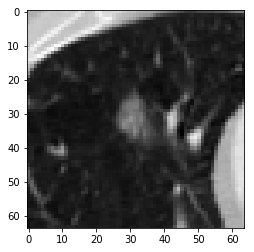

In [28]:
plt.imshow(data0[32,:,:],cmap='gray')

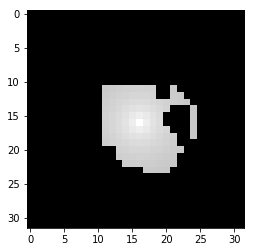

In [29]:
plt.imshow(label0[16,:,:,1],cmap='gray')

In [38]:
data1 = np.load('../unet_3d_traindata/LKDS-00011_data_0_0_-8_0.npy')
label1 = np.load('../unet_3d_traindata/LKDS-00011_label_0_0_-8_0.npy')
print(data1.shape,label1.shape)

(64, 64, 64) (32, 32, 32, 2)


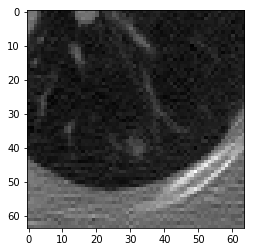

In [39]:
plt.imshow(data1[32,:,:],cmap='gray')

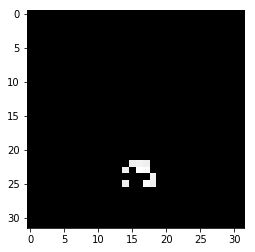

In [55]:
plt.imshow(label1[19,:,:,1],cmap='gray')

In [11]:
f = open('../nodule_cubes/val_data/pkl/origion.pkl','rb')
origins = pickle.load(f)
f.close()

f = open('../nodule_cubes/val_data/pkl/new_spacing.pkl','rb')
new_spacings = pickle.load(f)
f.close()

In [51]:
ct_id = "LKDS-00851"
train_data = np.load('../nodule_cubes/val_data/npy/'+ct_id+'.npy')

origin = origins[ct_id]
spacing = new_spacings[ct_id]
print(train_data.shape)
# print(val_meta[ct_id])
# cz,cy,cx= val_meta[ct_id]['grounds'][0]

cz,cy,cx = world_2_voxel(np.array([166.50,-4.25,105.40]),origin,spacing)
print(cz,cy,cx)

(295, 350, 350)
171.25 170.749940447 285.39990046


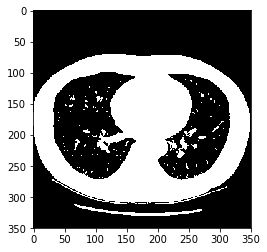

In [52]:
plt.imshow(train_data[171,:,:]>-600,cmap='gray')

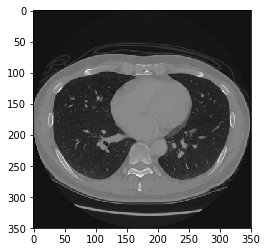

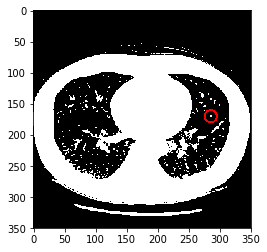

In [53]:
plt.imshow(train_data[171,:,:],cmap='gray')
plt.show()
mask = train_data[int(cz),:,:]  > -700
mask = mask.astype('uint8')
mask *= 255
rgb = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
cv2.circle(rgb,(int(cx),int(cy)),10,[255,0,0],2)
plt.imshow(rgb,cmap='gray')
plt.show()

In [38]:
data_mask = np.load('../valdata_masks/LKDS-00002.npy')
print(data_mask.shape)

(591, 512, 512)


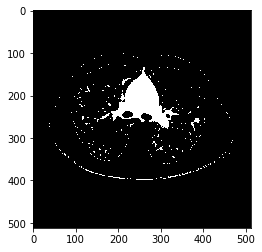

In [42]:
plt.imshow(data_mask[211,:,:],cmap='gray')

### 验证集、训练集数据预测

In [7]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
saver = tf.train.Saver()
saver.restore(sess,'./unet3d_models_7/ecpho_7/unet3d_model.ckpt')

INFO:tensorflow:Restoring parameters from ./unet3d_models_7/ecpho_7/unet3d_model.ckpt


In [8]:
import time
import os

val_datafiles = glob.glob('../nodule_cubes/val_data/npy/*.npy')
# val_datamasks = glob.glob('../valdata_mask/*.npy')

np.random.shuffle(val_datafiles)

ind = 0
for val_datafile in val_datafiles[:10]:
    ind += 1
    t1 = time.time()
    ct_id = os.path.basename(val_datafile)[:-4]
    maskfile = '../valdata_masks/'+ct_id+'.npy'
    origin = np.load(val_datafile)
    normed_data = (origin.astype('float32')-(-1000))/(400 - (-1000))
    normed_data[normed_data > 1] = 1
    normed_data[normed_data < 0] = 0
    data_mask = np.load(maskfile)
    result3d = np.zeros_like(origin,dtype=np.float32)
    
    coords = []
    for az in range(0,origin.shape[0]-63,24):
        for ay in range(30,origin.shape[1]-63,24):
            for ax in range(20,origin.shape[2]-63,24):
#                 if np.sum(data_mask[az+30:az+34,ay+30:ay+34,ax+30:ax+34]) < 2:
#                     continue
#                 if np.sum(data_mask[az+20:az+40,ay+20:ay+40,ax+20:ax+40]) > 6000:
#                     continue
                coords.append([az,ay,ax])
    coords = np.array(coords)
    print(coords.shape[0])
    
#     inds = np.random.choice(np.arange(coords.shape[0]),int(coords.shape[0]*0.6))
#     coords = coords[inds]
    
    for i in range(0,coords.shape[0],30):
        tmp_data = []
        for tz,ty,tx in coords[i:i+30]:
            tmp_data.append(normed_data[tz:tz+64,ty:ty+64,tx:tx+64])
        tmp_data = np.array(tmp_data)
        prediction,val_output_shape = sess.run([predictor,logits_shape],feed_dict={input_x:tmp_data,keep_prob:0.5})
        for j in range(prediction.shape[0]):
            tz,ty,tx = coords[i+j,:]
            result3d[tz+16:tz+48,ty+16:ty+48,tx+16:tx+48] = np.maximum(result3d[tz+16:tz+48,ty+16:ty+48,tx+16:tx+48],prediction[j,:,:,:,1])
    np.save('../unet3d_prediction/'+ct_id+'.npy',result3d)
    t2 = time.time()
    print('[ %d ] %s num : %d ,time : %f ' % (ind,ct_id,coords.shape[0],t2-t1))



1296
[ 1 ] LKDS-00644 num : 1296 ,time : 87.305805 
1848
[ 2 ] LKDS-00276 num : 1848 ,time : 118.239371 
900
[ 3 ] LKDS-00172 num : 900 ,time : 56.998324 
936
[ 4 ] LKDS-00353 num : 936 ,time : 59.509210 
1452
[ 5 ] LKDS-00588 num : 1452 ,time : 93.831174 
2028
[ 6 ] LKDS-00853 num : 2028 ,time : 126.355228 
7956
[ 7 ] LKDS-00748 num : 7956 ,time : 496.964527 
1248
[ 8 ] LKDS-00376 num : 1248 ,time : 78.831475 
2028
[ 9 ] LKDS-00685 num : 2028 ,time : 127.308609 
1848
[ 10 ] LKDS-00828 num : 1848 ,time : 116.333400 


In [9]:
tt = np.load('../unet3d_prediction/LKDS-00644.npy')
print(tt.shape)

(261, 366, 366)


In [5]:
np.sum(tt>0.5)

114033

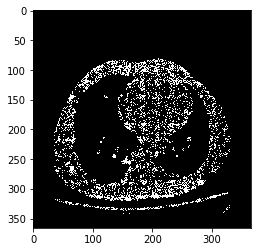

In [10]:
plt.imshow(tt[171]>0.4,cmap='gray')

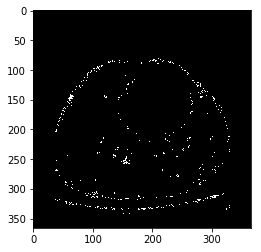

In [11]:
plt.imshow(tt[171]>0.5,cmap='gray')

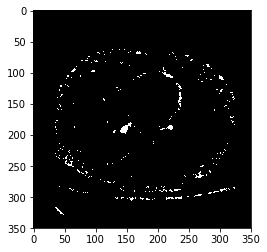

In [22]:
mask = tt[167]>0.5
disk = skimage.morphology.disk(2)
tmp = np.zeros_like(mask)
skimage.morphology.binary_closing(mask,selem=disk,out=tmp)
plt.imshow(tmp,cmap='gray')

In [12]:
import pickle

prediction_files = glob.glob('../unet3d_prediction/*.npy')

f = open('../nodule_cubes/val_data/pkl/origion.pkl','rb')
origins = pickle.load(f)
f.close()

f = open('../nodule_cubes/val_data/pkl/new_spacing.pkl','rb')
new_spacings = pickle.load(f)
f.close()

ct_ids = []
probs = []
coordZs = []
coordYs = []
coordXs = []

# np.random.shuffle(prediction_files)
disk = skimage.morphology.disk(2)
for prediction_file in prediction_files[:]:
    prediction = np.load(prediction_file)
    mask_3d = prediction > 0.50
    ct_id = os.path.basename(prediction_file)[:-4]
    origin = origins[ct_id]
    spacing = new_spacings[ct_id]
    prediction_mask = np.load('../resized_valdata_masks/'+ct_id+'.npy')
    coords = np.argwhere(mask_3d)
    count = 0
    for idx in range(coords.shape[0]):
        coord = coords[idx]
        if prediction_mask[coord[0],coord[1],coord[2]] == 0:
            prediction[coord[0],coord[1],coord[2]] = 0
            mask_3d[coord[0],coord[1],coord[2]] = 0
    
    for idx in range(mask_3d.shape[0]):
        mask_tmp = np.zeros_like(mask_3d[idx])
        skimage.morphology.binary_closing(mask_3d[idx,:,:],selem=disk,out = mask_tmp)
        mask_3d[idx,:,:] = mask_tmp[:,:]
    
    measured = skimage.measure.label(mask_3d)
    regions = regionprops(measured)
    for region in regions:
        coords = region.coords
        area = region.area
        center = coords.mean(axis=0)
        if area < 30:
            count += 1
            prob = prediction[int(center[0]),int(center[1]),int(center[2])]
            coordz,coordy,coordx = voxel_2_world(center,origin,spacing)
            coordZs.append(coordz)
            coordYs.append(coordy)
            coordXs.append(coordx)
            probs.append(prob)
            ct_ids.append(ct_id)
            continue
            
        tmp_probs = []
        for coord in coords:
            tmp_prob = prediction[coord[0],coord[1],coord[2]]
            tmp_probs.append(tmp_prob)
        core_coord = coords[np.argmax(tmp_probs)]
        coordz,coordy,coordx = voxel_2_world(core_coord,origin,spacing)
        core_prob = tmp_probs[np.argmax(tmp_probs)]
        coordZs.append(coordz)
        coordYs.append(coordy)
        coordXs.append(coordx)
        probs.append(core_prob)
        ct_ids.append(ct_id)
        
        if area < 200:
            inds = []
            for _ in range(20):
                ind = np.random.choice(np.arange(int(area)),1)
                coord = coords[ind][0]
                prob = prediction[coord[0],coord[1],coord[2]]
                if (np.linalg.norm(coord-core_coord) > 3) and (ind not in inds) and ((core_prob - prob) < 0.1):
                    count += 1
                    inds.append(ind)
                    coordz,coordy,coordx = voxel_2_world(coord,origin,spacing)
                    coordZs.append(coordz)
                    coordYs.append(coordy)
                    coordXs.append(coordx)
                    probs.append(prob)
                    ct_ids.append(ct_id)
                    continue
        
        
        
        inds = []
        for _ in range(120):
            ind = np.random.choice(np.arange(int(area)),1)
            coord = coords[ind][0]
            prob = prediction[coord[0],coord[1],coord[2]]
            if (np.linalg.norm(coord-core_coord) > 6) and (ind not in inds) and ((core_prob - prob) < 0.1):
                count += 1
                inds.append(ind)
                coordz,coordy,coordx = voxel_2_world(coord,origin,spacing)
                coordZs.append(coordz)
                coordYs.append(coordy)
                coordXs.append(coordx)
                probs.append(prob)
                ct_ids.append(ct_id)
                continue


    #np.save(prediction_file,prediction)
    print("[ %s ] before : %d ,after : %d" % (ct_id,count,len(regions)))
    

[ LKDS-00172 ] before : 4585 ,after : 4252
[ LKDS-00276 ] before : 6131 ,after : 5839
[ LKDS-00353 ] before : 2911 ,after : 2682
[ LKDS-00376 ] before : 3541 ,after : 3354
[ LKDS-00588 ] before : 4912 ,after : 4630
[ LKDS-00644 ] before : 4457 ,after : 4251
[ LKDS-00685 ] before : 6620 ,after : 6270
[ LKDS-00748 ] before : 6695 ,after : 6369
[ LKDS-00828 ] before : 4964 ,after : 4590
[ LKDS-00853 ] before : 5038 ,after : 4763


In [13]:
import pandas as pd

df = pd.DataFrame({'seriesuid':ct_ids,'coordZ':coordZs,'coordY':coordYs,'coordX':coordXs,'probability':probs})
df.to_csv('unet3d_result.csv',index=False)

In [100]:
df.head()

,coordX,coordY,coordZ,probability,seriesuid
0,-41.053965,-124.089142,12.800000,0.703482,LKDS-00002
1,-63.968018,-124.907501,20.499999,0.522195,LKDS-00002
2,-85.245352,-139.637964,26.099999,0.507359,LKDS-00002
3,40.781936,-119.997347,27.499999,0.543271,LKDS-00002
4,35.053423,-111.813757,32.399999,0.528025,LKDS-00002


In [74]:
import glob
import os
import time

train_datafiles = glob.glob('../valdata_pkl/*.npy')
count = 0
for train_datafile in train_datafiles[:]:
    count += 1
    t1 = time.time()
    train_data = np.load(train_datafile)
    ct_id = os.path.basename(train_datafile)[:-4]
    save_path = '../valdata_masks/'+ct_id+'.npy'
    #if os.path.exists(save_path):
        #continue
    result3d = np.zeros_like(train_data)
    disk = skimage.morphology.disk(5)
    for i in range(train_data.shape[0]):
        mask = train_data[i,:,:] > -600
        tmp = np.zeros_like(mask)
        skimage.morphology.binary_opening(mask,selem=disk,out=tmp)
        measured = skimage.measure.label(tmp)
        regions = skimage.measure.regionprops(measured)
        regions = sorted(regions,key=lambda r:r.area,reverse=True)
        for region in regions[1:]:
            coords = region.coords
            for coord in coords:
                tmp[coord[0],coord[1]] = 0
        mask = train_data[i,:,:] > -700
        tmp_result = np.bitwise_xor(mask,tmp)
        tmp_result = skimage.segmentation.clear_border(tmp_result)
        tmp_disk = skimage.morphology.disk(2)
        tmp = np.zeros_like(mask)
        skimage.morphology.binary_dilation(tmp_result,selem=tmp_disk,out=tmp)
        #meauserd = skimage.measure.label(tmp)
        #regions = skimage.measure.regionprops(meauserd)
        #regions = sorted(regions,key=lambda arg:arg.area,reverse=True)
        #tmp_out = np.zeros_like(mask)
        #for region in regions[:2]:
         #   for tx,ty in region.coords:
          #      tmp_out[tx,ty] = 1
        
        result3d[i,:,:] = np.bitwise_and(tmp_result,tmp)
    np.save(save_path,result3d)
    t2 = time.time()
    print("[ %d %s %f ]" % (count,ct_id,t2-t1))

[ 1 LKDS-00002 15.111971 ]
[ 2 LKDS-00006 14.850761 ]
[ 3 LKDS-00008 8.783515 ]


KeyboardInterrupt: 

In [119]:
import glob
import os
import time

train_datafiles = glob.glob('../valdata_pkl/*.npy')
count = 0
for train_datafile in train_datafiles[:]:
    count += 1
    t1 = time.time()
    train_data = np.load(train_datafile)
    ct_id = os.path.basename(train_datafile)[:-4]
    save_path = '../valdata_masks/'+ct_id+'.npy'
    #if os.path.exists(save_path):
        #continue
    result_mask3d = np.zeros_like(train_data)
    for i in range(train_data.shape[0]):
        mask = train_data[i] > -600
        disk = skimage.morphology.disk(5)
        tmp1 = np.zeros_like(mask)
        skimage.morphology.binary_opening(mask,selem=disk,out=tmp1)
        meausred = label(tmp1)
        regions = regionprops(meausred)
        regions = sorted(regions,key=lambda r:r.area,reverse=True)
        for r in regions[1:]:
            coords = r.coords
            for coord in coords:
                tmp1[coord[0],coord[1]] = 0
        mask = train_data[i] > -700
        disk = skimage.morphology.disk(5)
        tmp2 = np.zeros_like(mask)
        skimage.morphology.binary_dilation(mask,selem=disk,out=tmp2)
        measuered = label(tmp2)
        regions = regionprops(measuered)
        regions = sorted(regions,key=lambda r:r.area,reverse=True)
        for region in regions[1:]:
            coords = region.coords
            for cx,cy in coords:
                tmp2[cx,cy] = 0
        tmp3 = np.bitwise_and(mask,tmp2)
        tmp2 = np.bitwise_xor(tmp1,tmp3)
        disk = skimage.morphology.disk(1)
        tmp3 = skimage.morphology.binary_dilation(tmp2,selem=disk)
        tmp1 = clear_border(tmp3)
        result_mask3d[i,:,:] = np.bitwise_and(tmp2,tmp1)
    np.save(save_path,result_mask3d)
    t2 = time.time()
    print("[ %d %s %f ]" % (count,ct_id,t2-t1))

[ 1 LKDS-00002 33.154730 ]
[ 2 LKDS-00006 24.575217 ]
[ 3 LKDS-00008 17.127676 ]
[ 4 LKDS-00009 16.582665 ]
[ 5 LKDS-00010 17.047099 ]
[ 6 LKDS-00014 13.263974 ]
[ 7 LKDS-00017 12.387539 ]
[ 8 LKDS-00018 25.132138 ]
[ 9 LKDS-00024 14.631619 ]
[ 10 LKDS-00032 18.442744 ]
[ 11 LKDS-00045 13.903500 ]
[ 12 LKDS-00048 29.206207 ]
[ 13 LKDS-00055 21.279819 ]
[ 14 LKDS-00059 16.913303 ]
[ 15 LKDS-00060 26.071715 ]
[ 16 LKDS-00067 19.088675 ]
[ 17 LKDS-00069 15.352309 ]
[ 18 LKDS-00071 15.361076 ]
[ 19 LKDS-00072 11.439435 ]
[ 20 LKDS-00080 11.111553 ]
[ 21 LKDS-00086 14.807965 ]
[ 22 LKDS-00113 11.599208 ]
[ 23 LKDS-00115 19.180905 ]
[ 24 LKDS-00121 22.281838 ]
[ 25 LKDS-00123 27.315559 ]
[ 26 LKDS-00125 20.865943 ]
[ 27 LKDS-00128 18.795923 ]
[ 28 LKDS-00130 12.240114 ]
[ 29 LKDS-00138 12.249719 ]
[ 30 LKDS-00141 16.310938 ]
[ 31 LKDS-00145 14.862299 ]
[ 32 LKDS-00146 22.854043 ]
[ 33 LKDS-00148 30.915375 ]
[ 34 LKDS-00153 11.119447 ]
[ 35 LKDS-00161 28.200116 ]
[ 36 LKDS-00163 18.597680 ]
[

KeyboardInterrupt: 

In [120]:
import glob
import os
import time

train_datafiles = glob.glob('../nodule_cubes/val_data/npy/*.npy')
count = 0
for train_datafile in train_datafiles[:]:
    count += 1
    t1 = time.time()
    train_data = np.load(train_datafile)
    ct_id = os.path.basename(train_datafile)[:-4]
    save_path = '../resized_valdata_masks/'+ct_id+'.npy'
    result_mask3d = np.zeros_like(train_data)
    disk = skimage.morphology.disk(5)
    for i in range(train_data.shape[0]):
        mask = train_data[i] < -600
        tmp = np.zeros_like(mask)
        skimage.morphology.binary_dilation(mask,selem=disk,out=tmp)
        cleared = clear_border(tmp)
        result_mask3d[i,:,:] = cleared[:,:]
        
    np.save(save_path,result_mask3d)
    t2 = time.time()
    print("[ %d %s %f ]" % (count,ct_id,t2-t1))

[ 1 LKDS-00002 3.420715 ]
[ 2 LKDS-00006 2.316464 ]
[ 3 LKDS-00008 2.102210 ]
[ 4 LKDS-00009 2.788738 ]
[ 5 LKDS-00010 4.340834 ]
[ 6 LKDS-00014 2.549039 ]
[ 7 LKDS-00017 2.489507 ]
[ 8 LKDS-00018 2.992262 ]
[ 9 LKDS-00024 2.436633 ]
[ 10 LKDS-00032 2.997989 ]
[ 11 LKDS-00045 2.076540 ]
[ 12 LKDS-00048 2.986247 ]
[ 13 LKDS-00055 6.589551 ]
[ 14 LKDS-00059 2.722981 ]
[ 15 LKDS-00060 2.614075 ]
[ 16 LKDS-00067 3.785329 ]
[ 17 LKDS-00069 2.509820 ]
[ 18 LKDS-00071 2.589662 ]
[ 19 LKDS-00072 2.458911 ]
[ 20 LKDS-00080 2.109376 ]
[ 21 LKDS-00086 2.677634 ]
[ 22 LKDS-00113 2.362517 ]
[ 23 LKDS-00115 3.008454 ]
[ 24 LKDS-00121 2.571785 ]
[ 25 LKDS-00123 2.851527 ]
[ 26 LKDS-00125 8.195948 ]
[ 27 LKDS-00128 2.708191 ]
[ 28 LKDS-00130 2.318049 ]
[ 29 LKDS-00138 3.350427 ]
[ 30 LKDS-00141 2.176796 ]
[ 31 LKDS-00145 3.529581 ]
[ 32 LKDS-00146 2.780962 ]
[ 33 LKDS-00148 2.940868 ]
[ 34 LKDS-00153 2.447239 ]
[ 35 LKDS-00161 4.089303 ]
[ 36 LKDS-00163 2.829546 ]
[ 37 LKDS-00166 3.517176 ]
[ 38 LKDS-